In [31]:
import numpy as np
import pandas as pd
import os
import urllib
import ast
import math
import datetime
import random
from collections import defaultdict
from matplotlib import pyplot as plt
from pdb import set_trace as bp
# from LFM import LFM

In [2]:
def getData(filepath):
    with open(filepath) as f:
        data = f.readlines()
        data2 = map( lambda x : x.replace("\'", "'").strip(), data )
        data3 = map( lambda x : ast.literal_eval(x) , data2)
        return pd.DataFrame(data3)
    
dirpath = './data/'
filepath = os.path.join(dirpath, 'train.json')
df_data = getData(filepath) 

In [229]:
import progressbar

class LFM:
    def __init__(self, data, nComponents = 10, \
                 userID = 'userID', itemID = 'businessID',\
                 target = 'rating' , timeStamp = 'unixReviewTime', \
                 mean = 0, std = 0.1, reg = 0.01, split_percent = 0.6):
        self.userID = userID
        self.itemID = itemID
        self.target = target
        self.timeStamp = timeStamp
        self.data = data
        self.nData = self.data.shape[0]
        self.nComponents = nComponents
        self.mean = mean
        self.std = std
        self.reg = reg

        self.userList, self.bussList = self.getUniqueUserBusinessList()
        self.nUser = len( self.userList )
        self.nBuss = len( self.bussList )
        self.userIndexDict, self.bussIndexDict = self.getUserBussIndexDict()
        self.__train_validate_test_split__(split_percent)
        self.userInfoDict, self.bussInfoDict = self.getUserBussInfoDict()
        
    def __getTimeInfo__(self,utime):
        t = datetime.datetime.fromtimestamp( utime ).timetuple()
        yy = t[0]
        mm = t[1]
        retValue = 0
        if( yy < 2011 ):
            retValue = 0
        else:
            yydiff = yy-2011
            mmdiff = mm-0
            retValue = yydiff*12 + mmdiff

        return retValue

    def getUniqueUserBusinessList(self):
        bussList = list((set(self.data[self.itemID])))
        userList = list((set(self.data[self.userID])))
        return userList, bussList

    def getUserBussIndexDict(self):
        userIndexDict = defaultdict(int)
        bussIndexDict = defaultdict(int)
        for index,user in enumerate(self.userList):
            userIndexDict[user] = index
        for index, buss in enumerate(self.bussList):
            bussIndexDict[buss] = index
        return userIndexDict, bussIndexDict   

    def getUserBussInfoDict(self):
        uDict = defaultdict(list)
        bDict = defaultdict(list)
        for index,row in self.trainData.iterrows():
            bussIndex = self.bussIndexDict[row[self.itemID]]
            userIndex = self.userIndexDict[row[self.userID]]
#             bp()
            time = self.__getTimeInfo__(row[self.timeStamp])
            rating = row[self.target]

            uDict[ userIndex ].append( [bussIndex, rating, time ])
            bDict[ bussIndex ].append( [userIndex, rating, time ] )
        return uDict, bDict
        
       
    ############################################################################################
    ############################################################################################
    ############################ API's to train the model ######################################

    def __getInitialBias__(self):
        self.betaU = np.zeros( self.nUser )
        self.betaI = np.zeros( self.nBuss )
        self.alpha = 0
        for userIndex, userInfo in self.userInfoDict.iteritems():
            for [bussIndex, trueRating, timeStamp] in userInfo:
                self.betaU[userIndex] += trueRating
                self.alpha += trueRating
            self.betaU[userIndex] /= float(len(userInfo))
        for bussIndex, bussInfo in self.bussInfoDict.iteritems():
            for [userIndex, trueRating, timeStamp] in bussInfo:
                self.betaI[bussIndex] += trueRating
            self.betaI[bussIndex] /= float(len(bussInfo))
        self.alpha /= float(self.nTrainData)

        
    def initializeParams(self):
            self.__getInitialBias__() ## initializes alpha, betaU, betaI
            self.gammaU = np.random.normal(self.mean, self.std, (self.nUser, self.nComponents))
            self.gammaI = np.random.normal(self.mean, self.std, (self.nBuss, self.nComponents))
            self.tGrad  = 0.00

    def __updateAlpha__(self):
        ## update alpha : 
#         bp()
        sumRatingError = 0
        for userIndex, userInfo in self.userInfoDict.iteritems():
            for [bussIndex, trueRating, timeStamp] in userInfo:
#                 bp()
                predRating = self.betaU[userIndex] + self.betaI[bussIndex] #+ self.tGrad*timeStamp #+ np.dot( self.gammaU[userIndex], self.gammaI[bussIndex]) # + self.tGrad*timeStamp
                ratingError = trueRating - predRating
                sumRatingError += ratingError
        self.alpha = sumRatingError/float(self.nTrainData)

    def __updateBetaU__(self):
        for userIndex, userInfo in self.userInfoDict.iteritems():
            sumRatingError = 0
            for [bussIndex, trueRating ,timeStamp] in userInfo:
                predRating = self.alpha + self.betaI[bussIndex] #+ timeStamp*self.tGrad #+ np.dot(self.gammaU[userIndex], self.gammaI[bussIndex]) #+ self.tGrad*timeStamp
                ratingError = trueRating - predRating
                sumRatingError += ratingError
            self.betaU[userIndex] = 1.0*sumRatingError/float( self.reg + len(userInfo)  )

    def __updateBetaI__(self):
        for bussIndex, bussInfo in self.bussInfoDict.iteritems():
            sumRatingError = 0
            for [userIndex, trueRating ,timeStamp] in bussInfo:
                predRating = self.alpha + self.betaU[userIndex] #+ self.tGrad*timeStamp #+ np.dot(self.gammaU[userIndex], self.gammaI[bussIndex]) #+ self.tGrad*timeStamp
                ratingError = trueRating - predRating
                sumRatingError += ratingError
            self.betaI[bussIndex] = sumRatingError/float( self.reg + len(bussInfo)  )

    def __updateGammaU__(self):
        for userIndex, userInfo in self.userInfoDict.iteritems():
            numSum = 0
            denSum = 0
            for [bussIndex, trueRating, timeStamp] in userInfo:
                num1 = self.alpha + self.betaU[userIndex] + self.betaI[bussIndex] #+ self.tGrad*timeStamp#+ np.dot( self.gammaU[userIndex], self.gammaI[bussIndex]) #+ self.tGrad*timeStamp
                num = (trueRating - num1) * self.gammaI[bussIndex]
                numSum += num
                denSum += np.dot(self.gammaI[bussIndex], self.gammaI[bussIndex])
            self.gammaU[userIndex] = numSum/float(self.reg + denSum)

    def __updateGammaI__(self):
        for bussIndex, bussInfo in self.bussInfoDict.iteritems():
            numSum = 0
            denSum = 0
            for [userIndex, trueRating, timeStamp] in bussInfo:
                num1 = self.alpha + self.betaU[userIndex] + self.betaI[bussIndex] #+ self.tGrad*timeStamp#+ np.dot( self.gammaU[userIndex], self.gammaI[bussIndex]) #+ self.tGrad*timeStamp
                num = (trueRating - num1) * self.gammaU[userIndex]
                numSum += num
                denSum += np.dot(self.gammaU[userIndex], self.gammaU[userIndex])
            self.gammaI[bussIndex] = numSum/float(self.reg + denSum)

    def __updateTGrad__(self):
        sumRatingError = 0
        tSum = 0
        for userIndex, userInfo in self.userInfoDict.iteritems():
            for [bussIndex, trueRating, timeStamp] in userInfo:
                predRating = self.alpha + self.betaU[userIndex] + self.betaI[bussIndex] #+ np.dot( self.gammaU[userIndex], self.gammaI[bussIndex]) 
                ratingError = trueRating - predRating
                tSum += timeStamp
                sumRatingError += ratingError*timeStamp
        self.tGrad = sumRatingError/float(self.reg + tSum )

    def __updateVariables__(self, state ):
#         for i in range(10):
            self.__updateAlpha__()
            self.__updateBetaU__()
            self.__updateBetaI__()
#             if state:
#                 self.__updateGammaU__()
#             else :
#                 self.__updateGammaI__()
#             self.__updateTGrad__

    def __predictTimeStampForUser__(self, userID):
        userIndex = self.userIndexDict[userID]
        userInfo = self.userInfoDict[userIndex]
        if not len(userInfo):
            return 24
        timeSum = 0
        for [_,_,timeStamp] in userInfo:
            timeSum += timeStamp
        predictedTime = int( timeSum/float(len(userInfo)) )
        return predictedTime
        

    def loadParams(self, initializerValues):
        self.tGrad = 0.01
        self.alpha = initializerValues['alpha']
        self.betaU = initializerValues['betaU']
        self.betaI = initializerValues['betaI']
        self.gammaU = initializerValues['gammaU']
        self.gammaI = initializerValues['gammaI']
        
        
    def predictRatingFromID(self, userID, bussID, timeStamp = 0):
        
        userFound = userID in self.userIndexDict
        bussFound = bussID in self.bussIndexDict
        if timeStamp == 0 and userFound:
            timeStamp = self.__predictTimeStampForUser__(userID)
        if userFound:
            userIndex = self.userIndexDict[userID]
        if bussFound:
            bussIndex = self.bussIndexDict[bussID]
        if userFound and bussFound:
            predRating = self.alpha + self.betaU[userIndex] + self.betaI[bussIndex] + timeStamp*self.tGrad #+ np.dot(self.gammaU[userIndex], self.gammaI[bussIndex]) 
        elif userFound:
            predRating = self.alpha + self.betaU[userIndex] + timeStamp*self.tGrad
        elif bussFound:
            predRating = self.alpha + self.betaI[bussIndex] + timeStamp*self.tGrad
        else:
            predRating = self.alpha + timeStamp*self.tGrad
        return predRating
    
    def calculateLoss(self, testData , loss = 'mse' ):
        totError = 0
        nData = testData.shape[0]
        if nData == 0:
            return 0
        for index, row in testData.iterrows():
            trueTarget = row[self.target]
            predTarget = self.predictRatingFromID( row[self.userID], row[self.itemID], self.__getTimeInfo__(row['unixReviewTime']) )
            err = (trueTarget - predTarget )** 2
            totError += err
        mse = (totError/float(nData) )
        return mse
        
    def __train_validate_test_split__(self, split_percent = 0.6):
        shuffle = True
        validate_percent = 1-split_percent
#         np.random.seed(seed)
        perm = np.random.permutation(self.data.index) if shuffle else data.index
        m = len(self.data)
        train_end = int(split_percent * m)
        validate_end = int(validate_percent * m) + train_end
        self.trainData = self.data.iloc[perm[:train_end]]
        self.nTrainData = self.trainData.shape[0]
        self.validData = self.data.iloc[perm[train_end:validate_end]]
        self.nValidData = self.validData.shape[0]
#         self.test = data.iloc[perm[validate_end:]]
    
    def __initializeBestParameters__(self):
        self.bestParams = {}
        self.bestParams['mse']    = 1000000
        self.bestParams['alpha']  = 1000
        self.bestParams['betaU']  = 1000
        self.bestParams['betaI']  = 1000
        self.bestParams['gammaU'] = 1000
        self.bestParams['gammaI'] = 1000
    
    def __updateBestParameters__(self, validLoss):
        self.bestParams['mse'] = validLoss
        self.bestParams['alpha'] = self.alpha
        self.bestParams['betaU'] = self.betaU
        self.bestParams['betaI'] = self.betaI
        self.bestParams['gammaU'] = self.gammaU
        self.bestParams['gammaI'] = self.gammaI
    
    def printBestParams(self):
        print self.bestParams
    
    def train(self,nEpochs = 10, verbose = True, initializerValues = None ):
        print "Training Model"
#         self.__initializeVariables__(initializerValues)
        trainLoss = self.calculateLoss(self.trainData)
        state = True
        self.trainLossHist = []
        self.validLossHist = []
        self.__initializeBestParameters__()

        if not verbose:
            bar = progressbar.ProgressBar(  maxval=nEpochs, \
                                            widgets=[progressbar.Bar('=', '[', ']'), ' ', \
                                            progressbar.Percentage()] )
            bar.start()
        
        for i in range(nEpochs):
            self.__updateVariables__(state)
            state = not state
            trainLoss = self.calculateLoss(self.trainData)
            validLoss = self.calculateLoss(self.validData)
            self.trainLossHist.append(trainLoss)
            self.validLossHist.append(validLoss)
            if validLoss < self.bestParams['mse']:
                self.__updateBestParameters__(validLoss)
            if verbose: 
                print "Epoch: " + str(i+1) +"/" + str(nEpochs) + "\t Train Loss: " + str(round(trainLoss,5)) + "\t Valid Loss: "+ str(round(validLoss,5))
            else:
                bar.update(i)
                if i == nEpochs:
                    bar.finish()
        
        print "Training complete"
    
    def plotGraph(self):
        plt.plot(self.trainLossHist)
        plt.plot(self.validLossHist)
        plt.show()

In [234]:
model = LFM(df_data, reg = 4, nComponents = 1, split_percent = 1)

In [235]:
model.initializeParams()
# model.loadParams(bestParams)
model.train( nEpochs = 50, verbose = True )
model.printBestParams()
bestParams = model.bestParams()
model.plotGraph()

Training Model
Epoch: 1/50	 Train Loss: 3.2694	 Valid Loss: 0.0
Epoch: 2/50	 Train Loss: 2.5412	 Valid Loss: 0.0
Epoch: 3/50	 Train Loss: 1.96464	 Valid Loss: 0.0
Epoch: 4/50	 Train Loss: 1.5221	 Valid Loss: 0.0
Epoch: 5/50	 Train Loss: 1.19385	 Valid Loss: 0.0
Epoch: 6/50	 Train Loss: 0.95679	 Valid Loss: 0.0
Epoch: 7/50	 Train Loss: 0.78926	 Valid Loss: 0.0
Epoch: 8/50	 Train Loss: 0.67296	 Valid Loss: 0.0
Epoch: 9/50	 Train Loss: 0.59343	 Valid Loss: 0.0
Epoch: 10/50	 Train Loss: 0.53974	 Valid Loss: 0.0
Epoch: 11/50	 Train Loss: 0.5039	 Valid Loss: 0.0
Epoch: 12/50	 Train Loss: 0.48021	 Valid Loss: 0.0
Epoch: 13/50	 Train Loss: 0.46468	 Valid Loss: 0.0
Epoch: 14/50	 Train Loss: 0.4546	 Valid Loss: 0.0
Epoch: 15/50	 Train Loss: 0.44809	 Valid Loss: 0.0
Epoch: 16/50	 Train Loss: 0.44393	 Valid Loss: 0.0
Epoch: 17/50	 Train Loss: 0.44128	 Valid Loss: 0.0
Epoch: 18/50	 Train Loss: 0.43962	 Valid Loss: 0.0
Epoch: 19/50	 Train Loss: 0.43857	 Valid Loss: 0.0
Epoch: 20/50	 Train Loss: 0.43

KeyboardInterrupt: 

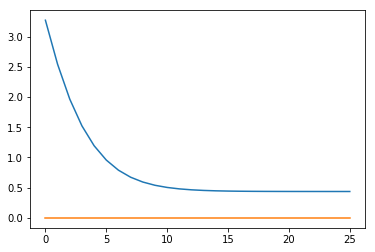

{'gammaU': array([[ 0.11824853],
       [-0.0926107 ],
       [ 0.01625382],
       ..., 
       [-0.06789413],
       [-0.02353296],
       [ 0.2309714 ]]), 'betaI': array([-0.50948035,  0.1037101 ,  0.41343619, ...,  0.06955939,
       -0.11570537, -0.41825152]), 'betaU': array([-0.09475088,  0.32470752, -0.11429931, ...,  0.34264163,
       -0.05383569, -0.29897647]), 'alpha': -4.1844850000000893, 'mse': 0, 'gammaI': array([[-0.08834105],
       [ 0.16265046],
       [ 0.05839092],
       ..., 
       [-0.16797647],
       [-0.14344498],
       [-0.00039535]])}


In [236]:
model.plotGraph()
model.printBestParams()

In [237]:
# import csv
# userList = []
# bussList = []
# with open(os.path.join(dirpath, 'pairs_Rating.csv'), 'rb') as csvfile:
#     data = csv.reader(csvfile, delimiter=',', quotechar='|')
#     for i,row in enumerate(data):
#         if i == 0:
#             continue;
#         userList.append(row[0])
#         bussList.append(row[1])
# print userList[0:5]
# print bussList[0:5]

# def prepareRatingPredictionFile(model, data):
#     predictions = open("data/predictions_Rating.txt", 'w')
#     predictions.write('userID-businessID,prediction\n')
#     for i, userBuss in enumerate(data):
#         u = userBuss[0]
#         b = userBuss[1]
#         prediction = model.predictRatingFromID(u,b) 
#         predictions.write(u + '-' + b + ',' + str(prediction) + '\n')
#     predictions.close()
    
# prepareRatingPredictionFile( model, zip(userList, bussList))

['U484183079', 'U869401302', 'U432339197', 'U448608827', 'U881505651']
['B310008221', 'B446452519', 'B786213612', 'B819902435', 'B381436901']
